# Building an Image Classifier using ConvNets From Scratch

The Dogs vs. Cats Dataset :
* Need to download data on Kaggle with an account
* 25000 grayscale images of A×A pixels each, with 2 classes





In [1]:
import os, shutil, pathlib
original_dir = pathlib.Path("datasets/dogs_vs_cats/train")
print(original_dir)

datasets/dogs_vs_cats/train


In [2]:
new_base_dir = pathlib.Path("datasets/cats_vs_dogs_small")

try:
    #Create a subset folder of the entire image folder from Kaggle
    def make_subset(subset_name, start_index, end_index):
        for category in ("cat", "dog"):
            dir = new_base_dir / subset_name / category
            os.makedirs(dir)
            fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
            for fname in fnames:
                shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

    make_subset("train", start_index=0, end_index=1000)
    make_subset("validation", start_index=1000, end_index=1500)
    make_subset("test", start_index=1500, end_index=2500)
except:
    print("already created")

already created


In [3]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
print(tensorflow.__version__)

2.4.0


# Data Preprocessing using Generators :

Currently the data sits on folders as JPEG files. So data should be formatted as floatting-point tensors before being fed into the network. The steps are :
* Read Pictures files 
* Decode JPEG content to RGB grids of pixels 
* Convert these into floating-point tensors
* Rescale pixels values.

Keras gives utility function to do this automatically : 

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory #utility to convert JPEG to RGB tensors

train_dataset = image_dataset_from_directory(    #train_dataset is a generator
    new_base_dir / "train",   #target folder
    image_size=(180, 180),    #Resizes all images to 180x180
    batch_size=32)            #batches sizes

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**Displaying the shapes of the data and labels yielded by the `Dataset` :**

In [8]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break  #Need to break beacause train_dataset is a generator which never stop generating batches

2021-12-15 15:30:33.647438: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


# Model

In [18]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling


#Model with the Functional API
inputs = keras.Input(shape=(180, 180, 3)) 
x = Rescaling(1./255)(inputs)      #RESCALING LAYER !
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)   #Classification problem. Output proba between [0;1]
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 41, 41, 128)       7385

# Fitting the model 

In [15]:
#compiling the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#Callbacks for saving training steps
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",   #Name of the saved file
        save_best_only=True,  # if none of your epochs had better performance than an epoch in previous, that previous checkpoint won't be overwritten.
        monitor="val_loss")
]

#Fit the model
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 90s 1s/step - loss: 0.9739 - accuracy: 0.5208 - val_loss: 0.6895 - val_accuracy: 0.5010
Epoch 2/30
63/63 [==============================] - 103s 2s/step - loss: 0.6983 - accuracy: 0.5541 - val_loss: 0.6720 - val_accuracy: 0.5720
Epoch 3/30
63/63 [==============================] - 104s 2s/step - loss: 0.6933 - accuracy: 0.5752 - val_loss: 0.6639 - val_accuracy: 0.5730
Epoch 4/30
63/63 [==============================] - 94s 1s/step - loss: 0.6483 - accuracy: 0.6416 - val_loss: 0.6326 - val_accuracy: 0.6350
Epoch 5/30
63/63 [==============================] - 96s 2s/step - loss: 0.6000 - accuracy: 0.6674 - val_loss: 0.9326 - val_accuracy: 0.5430
Epoch 6/30
63/63 [==============================] - 98s 2s/step - loss: 0.6084 - accuracy: 0.6996 - val_loss: 0.5862 - val_accuracy: 0.6850
Epoch 7/30
63/63 [==============================] - 103s 2s/step - loss: 0.5159 - accuracy: 0.7550 - val_loss: 0.5711 - val_accuracy: 0.6910
Epoch 8/30
63/63 

# Curves of the training :

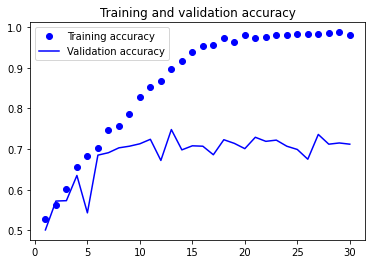

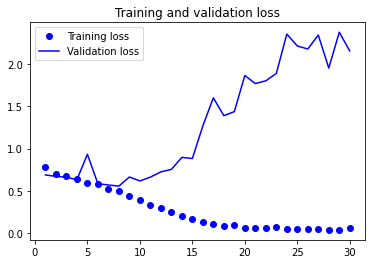

In [17]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Evaluating the model :

In [19]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 31s 477ms/step - loss: 0.5833 - accuracy: 0.7000
Test accuracy: 0.700


We can see there is overfitting here.

# Fitting Overfitting in CV :

In Computer Vision we fight overfittinh with data augmentation methods :

In [22]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

data_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.2),
    ]
)

We can visualize exemples of data augmentation : 

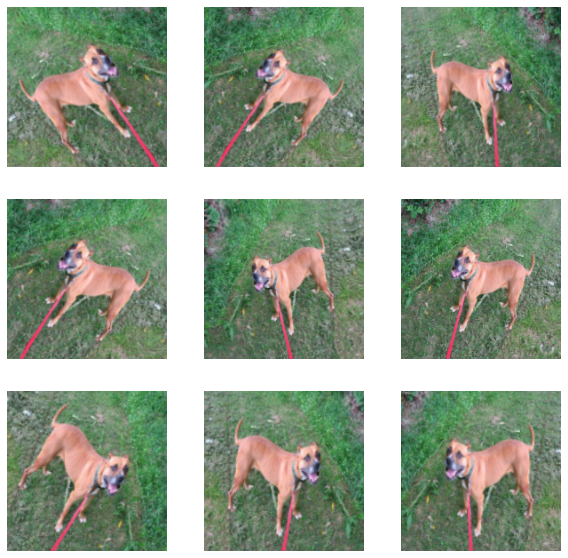

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

We can also add a dropout layer just before dense connected layers :

In [25]:
#New Model with DropOut Regularization 
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

NotImplementedError: Cannot convert a symbolic Tensor (sequential/random_rotation/rotation_matrix/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

By adding regularization techniques, we shown that the performance is better. We would also tune the parameters of the network as number of layers and the number of filters per convolution to gain performance. But it would difficult to prove this by training our own ConvNets from scratch with so little data.

A Next will be to use pre-trained models.